# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

<ipython-input-3-8c32cb05a179>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [4]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


## Question 1
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?

In [6]:
#removing NaN values from the dataset
saVouchersDropped = sa_vouchers_scores.dropna()

Text(0.5, 1.0, 'Voucher Value vs Participant LGA')

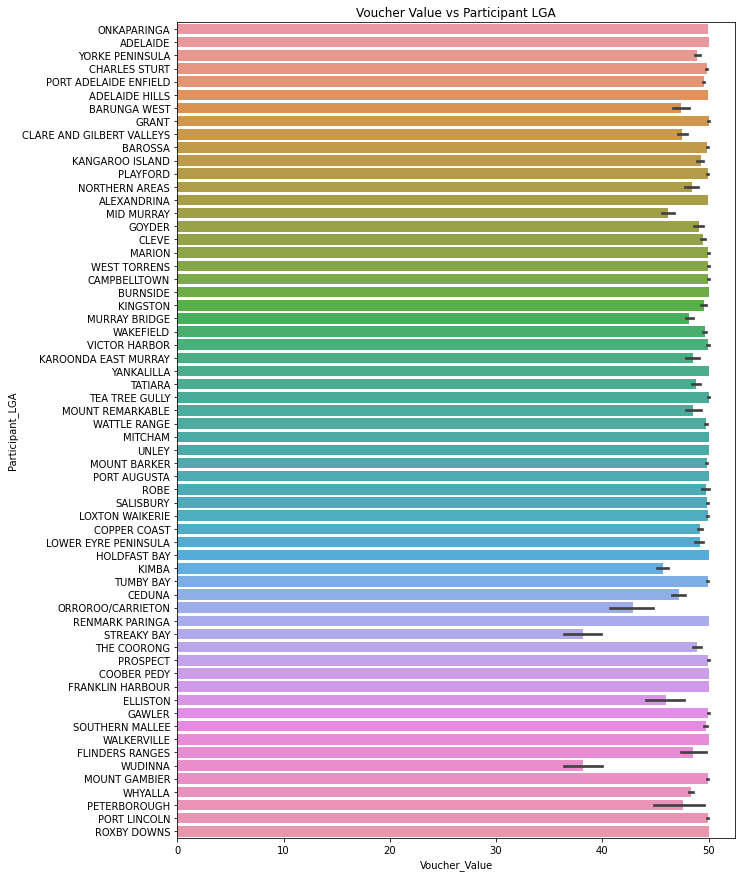

In [7]:
#graphing the voucher value to the participant LGA
plt.figure(figsize = (10,15))
sns.barplot(x = 'Voucher_Value', y = 'Participant_LGA', data = saVouchersDropped)
plt.title('Voucher Value vs Participant LGA')

Text(0.5, 1.0, 'Population vs Voucher Sport')

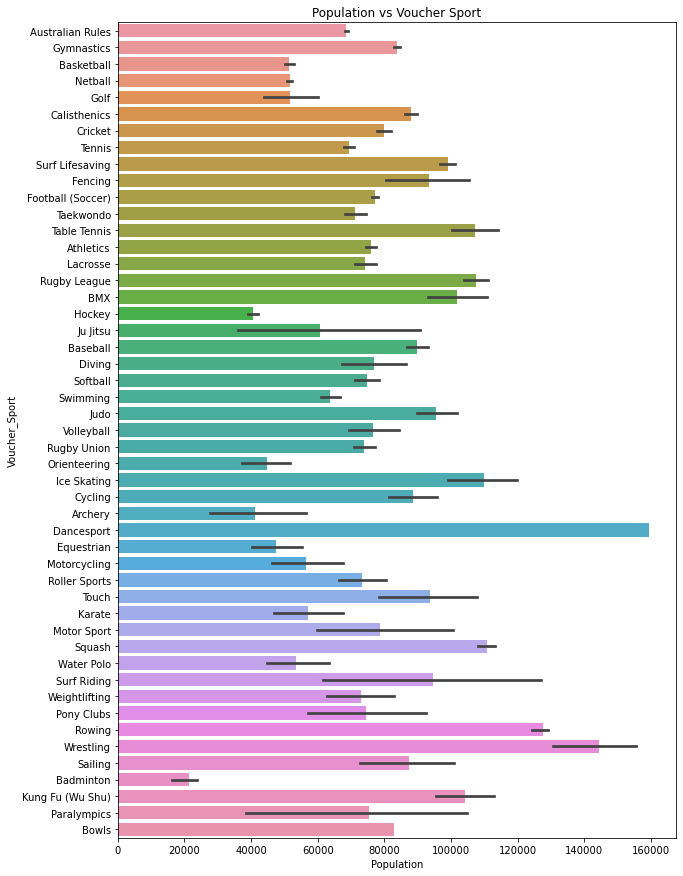

In [8]:
#graphing the population to the voucher_sport, shows most popular sport.
plt.figure(figsize = (10,15))
sns.barplot(x = 'Population', y = 'Voucher_Sport', data = saVouchersDropped)
plt.title('Population vs Voucher Sport')

I have created 2 different bar plots to represent the difference aspects of the distribution. With Voucher_Value and Participant_LGA, we can see which LGA's are using their vouchers more than others. Population and Voucher_Sport shows which sports are the most popular. Many of the LGA's stand out, but it is easier to see which ones have used less vouchers. For sport, Dancesport appears to be the most popular.

# Question 2
Are some sports more popular in different parts of the state?

In [9]:
#creating a pivot table to access the data easily.
saVouchDrop = sa_vouchers_scores.dropna()
table = pd.pivot_table(saVouchDrop, index = ['Participant_LGA'], columns = ['Voucher_Sport'], aggfunc = 'size', dropna = True, fill_value = 0)
table

Voucher_Sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,0,16,128,0,0,1,4,0,1,2,...,0,0,0,11,4,0,0,0,0,0
ADELAIDE HILLS,3,204,1358,2,0,11,48,0,62,128,...,0,18,3,44,249,2,1,1,0,0
ALEXANDRINA,9,62,973,4,3,0,180,0,5,8,...,2,11,0,0,109,0,0,0,0,0
BAROSSA,0,158,1191,3,0,6,339,0,9,56,...,0,12,0,0,83,0,0,0,0,0
BARUNGA WEST,0,1,86,0,0,0,12,0,0,1,...,0,0,0,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,1,114,895,2,0,12,67,0,44,85,...,0,74,4,27,158,1,4,2,0,0
WHYALLA,0,15,565,0,0,0,605,0,15,10,...,0,8,0,0,0,0,0,0,0,0
WUDINNA,0,29,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'LGA vs Sport')

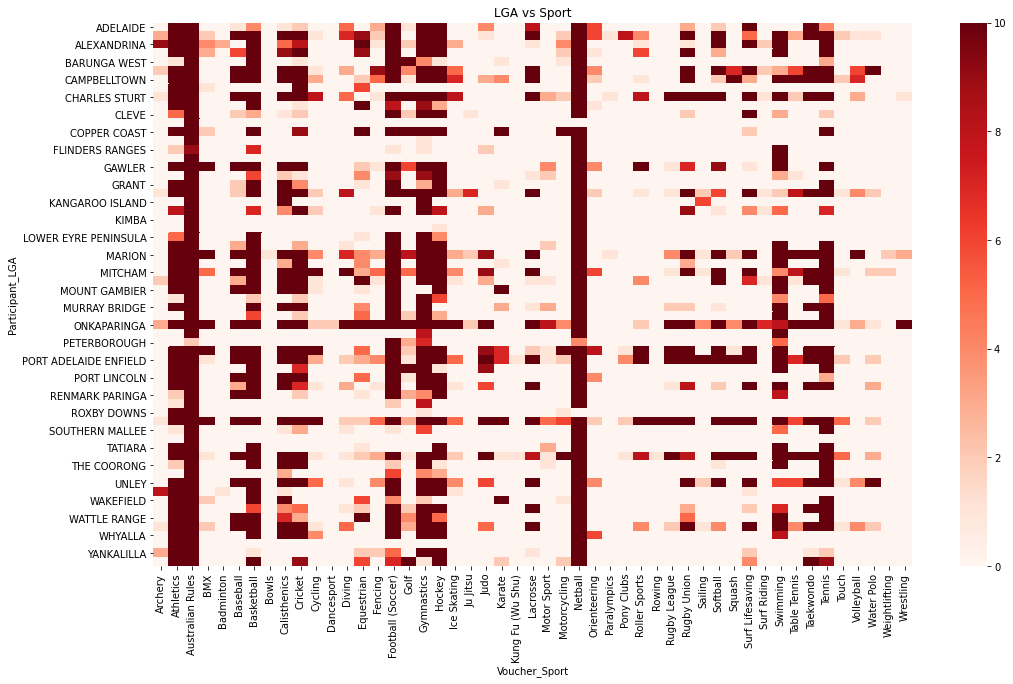

In [10]:
#creating a heatmap to visualise which sports are the most popular. Darker the colour, the more popular.
plt.figure(figsize=(17,10))
sns.heatmap(table, vmin = 0, vmax = 10, center = 5, cmap = 'Reds')
plt.title('LGA vs Sport')

From the heatmap above, we are able to visulise that the most popular sports across all states are as follows:
    Athelics, Australian Rules, Netball, Basketball, Gymnastics, and Football (Soccer)

# Question 3
Are any electorates over/under represented in their use of vouchers?

In [11]:
#calculating the percentage of voucher_values in participant_LGA
saVoucherValue = sa_vouchers_scores.groupby(['Participant_LGA'])\
.agg({'Voucher_Value' : 'sum'})[["Voucher_Value"]]\
.apply(lambda x: 100*x/x.sum())
saVoucherValue

,Voucher_Value
Participant_LGA,
ADELAIDE,0.238417
ADELAIDE HILLS,3.751039
ADELAIDE PLAINS,0.708003
ALEXANDRINA,2.349274
BAROSSA,2.263144
...,...
WEST TORRENS,2.243960
WHYALLA,1.900182
WUDINNA,0.160892


In [12]:
#calculating the percentage of population in participant_LGA
saVouchPopulation = sa_vouchers_scores.groupby(['Participant_LGA'])\
.agg({'Population' : 'sum'})[["Population"]]\
.apply(lambda x: 100*x/x.sum())
saVouchPopulation

,Population
Participant_LGA,
ADELAIDE,0.073735
ADELAIDE HILLS,2.286206
ADELAIDE PLAINS,0.000000
ALEXANDRINA,0.878953
BAROSSA,0.793607
...,...
WEST TORRENS,1.945494
WHYALLA,0.683798
WUDINNA,0.004176


In [13]:
#joining the two calculations into one dataset
totalPercent = pd.concat([saVoucherValue, saVouchPopulation], axis = 1, sort = False)
totalPercent

,Voucher_Value,Population
Participant_LGA,,
ADELAIDE,0.238417,0.073735
ADELAIDE HILLS,3.751039,2.286206
ADELAIDE PLAINS,0.708003,0.000000
ALEXANDRINA,2.349274,0.878953
BAROSSA,2.263144,0.793607
...,...,...
WEST TORRENS,2.243960,1.945494
WHYALLA,1.900182,0.683798
WUDINNA,0.160892,0.004176


Text(0.5, 1.0, 'Population vs Voucher Value')

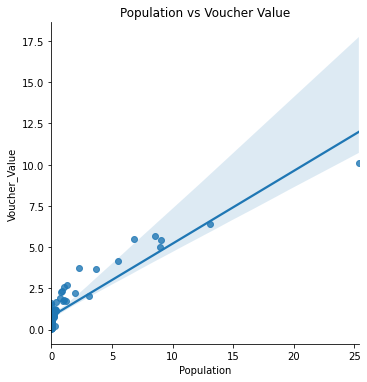

In [46]:
#graphing the distribution
sns.lmplot(x = 'Population', y = 'Voucher_Value', data = totalPercent)
plt.title('Population vs Voucher Value')

From the distribution above, we can see a positive coorlation between Population of the state to the Participant_LGA. Most of the electorates seem to be presented evenly within the dataset. There is a single outlier which is seen in the far right.

# Question 4
Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

In [15]:
#creating a new groupby table for the data required
saVouchAll = sa_vouchers_scores.groupby('Participant_LGA').sum()[['Voucher_Value']]
saVouchAll

,Voucher_Value
Participant_LGA,
ADELAIDE,15100
ADELAIDE HILLS,237570
ADELAIDE PLAINS,44841
ALEXANDRINA,148790
BAROSSA,143335
...,...
WEST TORRENS,142120
WHYALLA,120347
WUDINNA,10190


In [16]:
#calculating the mean of IEO, IER, IRSAD, and IRSD
saSEIFA = sa_vouchers_scores.groupby('Participant_LGA').mean()[['IEO', 'IER', 'IRSAD', 'IRSD']]
saSEIFA.dropna()

,IEO,IER,IRSAD,IRSD
Participant_LGA,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0
BAROSSA,1028.0,1028.0,997.0,1017.0
BARUNGA WEST,981.0,981.0,940.0,954.0
...,...,...,...,...
WEST TORRENS,949.0,949.0,989.0,998.0
WHYALLA,905.0,905.0,897.0,905.0
WUDINNA,1008.0,1008.0,999.0,1023.0


In [17]:
#joining the IEO, IER, IRSAD, IRSD, to the voucher value, to be able to plot the data
totalSEIFA = pd.concat([saVouchAll, saSEIFA], axis = 1, sort = False)
totalSEIFA

,Voucher_Value,IEO,IER,IRSAD,IRSD
Participant_LGA,,,,,
ADELAIDE,15100,874.0,874.0,1036.0,1013.0
ADELAIDE HILLS,237570,1083.0,1083.0,1077.0,1081.0
ADELAIDE PLAINS,44841,NaN,NaN,NaN,NaN
ALEXANDRINA,148790,1000.0,1000.0,969.0,987.0
BAROSSA,143335,1028.0,1028.0,997.0,1017.0
...,...,...,...,...,...
WEST TORRENS,142120,949.0,949.0,989.0,998.0
WHYALLA,120347,905.0,905.0,897.0,905.0
WUDINNA,10190,1008.0,1008.0,999.0,1023.0


Text(0.5, 1.0, 'Voucher Value vs IEO')

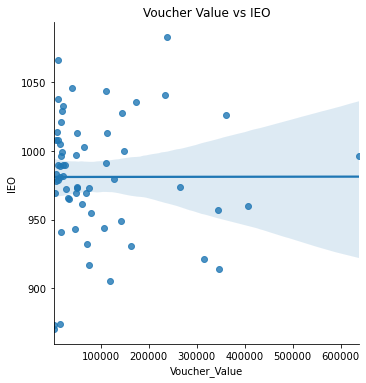

In [45]:
#plotting voucher value and IEO
sns.lmplot(x = 'Voucher_Value', y = 'IEO', data = totalSEIFA)
plt.title('Voucher Value vs IEO')

Text(0.5, 1.0, 'Voucher Value vs IER')

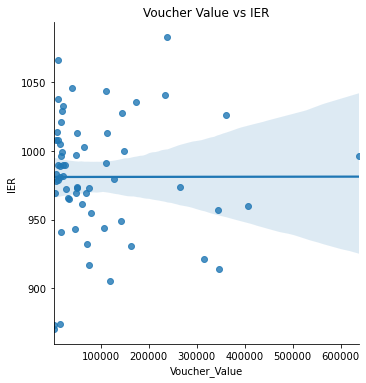

In [44]:
#plotting voucher value and IER
sns.lmplot(x = 'Voucher_Value', y = 'IER', data = totalSEIFA)
plt.title('Voucher Value vs IER')

Text(0.5, 1.0, 'Voucher Value vs IRSAD')

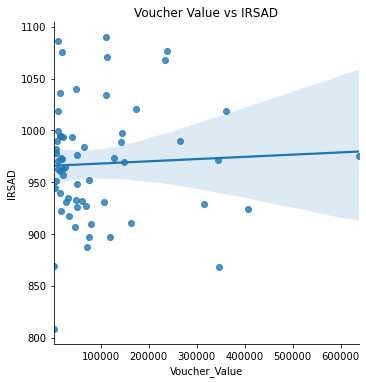

In [43]:
#plotting voucher value and IRSAD
sns.lmplot(x = 'Voucher_Value', y = 'IRSAD', data = totalSEIFA)
plt.title('Voucher Value vs IRSAD')

Text(0.5, 1.0, 'Voucher Value vs IRSD')

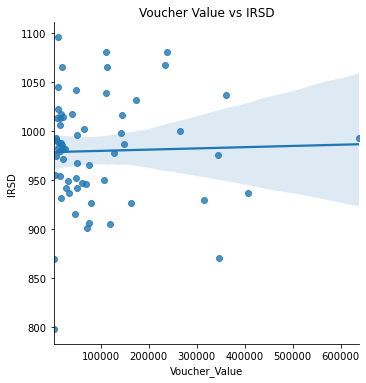

In [42]:
#plotting voucher value and IRSD
sns.lmplot(x = 'Voucher_Value', y = 'IRSD', data = totalSEIFA)
plt.title('Voucher Value vs IRSD')

Overall, observing the 4 plots that are generated above, Voucher Value has a similar distribution for all variables, IEO, IER, IRSAD, and IRSD. The Voucher Value for all 4 variables is quite low, only with IRSAD and IRSD having small amounts of high voucher values. This could be a result of certain LGAs using them more compared to others. Each plot does have a singular outlier, which can be observed as the highest uses of vouchers in a single LGA

Text(0.5, 1.0, 'Voucher Value and SEIFA correlated')

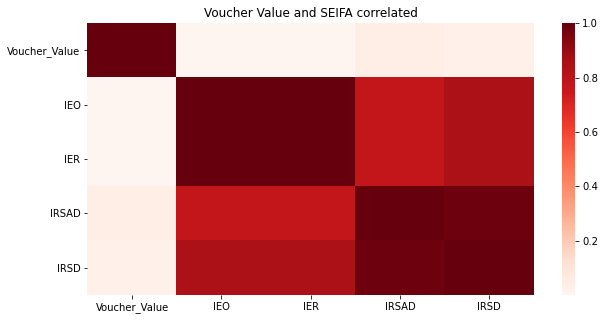

In [22]:
#plotting the above data into a heatmap for better visualisation
plt.figure(figsize=(10,5))
sns.heatmap(totalSEIFA.corr(), cmap = 'Reds')
plt.title('Voucher Value and SEIFA correlated')

From the heatmap, it provides another visualisation which helps use aid the relationship between voucher values and SEIFA. We can see, there is a very weak relationship from 0-0.5 for all 4 variables of SEIFA, but moving closer towards 1 shows a stronger relationship. From this, it represents that the voucher value is somewhat affordable to everyone in the public, hence the stronger relationship moving from 0.5-1 on the heatmap.

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [23]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [24]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

<ipython-input-24-d688531e2bfc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0


In [25]:
#joining SA vouchers and QLD vouchers
LGA =set(qld_vouchers_scores.LGA)
LGA

{'BANANA (S)',
 'BLACKALL TAMBO',
 'BRISBANE',
 'BUNDABERG',
 'BURDEKIN (S)',
 'CAIRNS',
 'CASSOWARY COAST',
 'CENTRAL HIGHLANDS',
 'CHARTERS TOWERS',
 'DOUGLAS (S)',
 'FLINDERS (S)',
 'FRASER COAST',
 'GLADSTONE',
 'GOLD COAST',
 'GYMPIE',
 'HERVEY BAY',
 'HINCHINBROOK (S)',
 'IPSWICH',
 'ISAAC',
 'LIVINGSTONE (S)',
 'LOCKYER VALLEY',
 'LOGAN',
 'LONGREACH',
 'MACKAY',
 'MARANOA',
 'MAREEBA (S)',
 'MCKINLAY (S)',
 'MORETON BAY',
 'MOUNT ISA',
 'MURWEH (S)',
 'NOOSA (S)',
 'NORTH BURNETT',
 'QUILPIE (S)',
 'REDLAND',
 'ROCKHAMPTON',
 'SCENIC RIM',
 'SOMERSET',
 'SOUTH BURNETT',
 'SOUTHERN DOWNS',
 'SUNSHINE COAST',
 'TABLELANDS',
 'TOOWOOMBA',
 'TOWNSVILLE',
 'WESTERN DOWNS',
 'WHITSUNDAY'}

In [26]:
#removing the (S) values form the data set
unwanted ={'BANANA (S)','BURDEKIN (S)','DOUGLAS (S)', 'FLINDERS (S)','HINCHINBROOK (S)','LIVINGSTONE (S)','MAREEBA (S)','MCKINLAY (S)', 'MURWEH (S)', 'NOOSA (S)','QUILPIE (S)',}
SA_LGA = [S for S
         in set (qld_vouchers_scores.LGA)
         if S in unwanted]
SA_LGA

['MCKINLAY (S)',
 'BURDEKIN (S)',
 'DOUGLAS (S)',
 'NOOSA (S)',
 'MURWEH (S)',
 'HINCHINBROOK (S)',
 'LIVINGSTONE (S)',
 'FLINDERS (S)',
 'MAREEBA (S)',
 'QUILPIE (S)',
 'BANANA (S)']

In [27]:
#returning all the data without (S)
unwanted ={'BANANA (S)','BURDEKIN (S)','DOUGLAS (S)', 'FLINDERS (S)','HINCHINBROOK (S)','LIVINGSTONE (S)','MAREEBA (S)','MCKINLAY (S)', 'MURWEH (S)', 'NOOSA (S)','QUILPIE (S)',}
QLD_LGA = [S for S
         in set (qld_vouchers_scores.LGA)
         if S not in unwanted]
QLD_LGA

['SUNSHINE COAST',
 'GYMPIE',
 'MOUNT ISA',
 'MARANOA',
 'WHITSUNDAY',
 'CENTRAL HIGHLANDS',
 'LOGAN',
 'IPSWICH',
 'LONGREACH',
 'TOWNSVILLE',
 'REDLAND',
 'HERVEY BAY',
 'GOLD COAST',
 'TOOWOOMBA',
 'NORTH BURNETT',
 'MORETON BAY',
 'BRISBANE',
 'GLADSTONE',
 'BLACKALL TAMBO',
 'CHARTERS TOWERS',
 'SOMERSET',
 'SOUTH BURNETT',
 'WESTERN DOWNS',
 'TABLELANDS',
 'SOUTHERN DOWNS',
 'LOCKYER VALLEY',
 'ROCKHAMPTON',
 'MACKAY',
 'FRASER COAST',
 'BUNDABERG',
 'CASSOWARY COAST',
 'ISAAC',
 'CAIRNS',
 'SCENIC RIM']

In [28]:
#creating a groupBy size() table
qldGroup = qld_vouchers_scores.groupby(['LGA', 'Participation Activity'], as_index = False).size()
qldGroup

,LGA,Participation Activity,size
0,BANANA (S),Equestrian,1
1,BANANA (S),Football (Soccer),1
2,BANANA (S),Netball,1
3,BLACKALL TAMBO,Athletics,2
4,BLACKALL TAMBO,Rugby League,1
...,...,...,...
424,WHITSUNDAY,*Other,1
425,WHITSUNDAY,Athletics,1
426,WHITSUNDAY,Gymnastics,2
427,WHITSUNDAY,Rugby League,12


In [29]:
#creating a pivot table and filled NaN values with 0 for further calculations
qldPivot = qldGroup.pivot('LGA', 'Participation Activity').fillna(0)
qldPivot

size                                        \
Participation Activity *Other Archery Athletics Australian Football   
LGA                                                                   
BANANA (S)                0.0     0.0       0.0                 0.0   
BLACKALL TAMBO            0.0     0.0       2.0                 0.0   
BRISBANE                 11.0     0.0       1.0                68.0   
BUNDABERG                 0.0     0.0       3.0                 3.0   
BURDEKIN (S)              0.0     0.0       0.0                 0.0   
CAIRNS                    0.0     0.0      17.0                24.0   
CASSOWARY COAST           0.0     0.0       0.0                 0.0   
CENTRAL HIGHLANDS         0.0     0.0       2.0                 0.0   
CHARTERS TOWERS           0.0     0.0       2.0                 0.0   
DOUGLAS (S)               0.0     0.0       4.0                 4.0   
FLINDERS (S)              0.0     0.0       0.0                 0.0   
FRASER COAST              0.0     0.0       0.0                13.0   
GLADSTONE                 0.0     0.0       0.0                 0.0   
GOLD COAST                1.0     0.0       2.0               172.0   
GYMPIE                    0.0     4.0       0.0                 3.0   
HERVEY BAY                0.0     0.0       0.0                 3.0   
HINCHINBROOK (S)          0.0     1.0       1.0                 2.0   
IPSWICH                   0.0     0.0       1.0                22.0   
ISAAC                     0.0     0.0       0.0                 0.0   
LIVINGSTONE (S)           0.0     0.0       0.0                 2.0   
LOCKYER VALLEY            0.0     0.0       0.0                 1.0   
LOGAN                     0.0     0.0      34.0                41.0   
LONGREACH                 0.0     0.0       0.0                 0.0   
MACKAY                    0.0     0.0       0.0                 1.0   
MARANOA                   0.0     0.0       0.0                 0.0   
MAREEBA (S)               0.0     0.0       0.0                 0.0   
MCKINLAY (S)              0.0     0.0       0.0                 0.0   
MORETON BAY               0.0     1.0       5.0                41.0   
MOUNT ISA                 0.0     0.0       0.0                 0.0   
MURWEH (S)                0.0     0.0       0.0                 0.0   
NOOSA (S)                 0.0     0.0       0.0                25.0   
NORTH BURNETT             0.0     0.0       1.0                 0.0   
QUILPIE (S)               0.0     0.0       0.0                 0.0   
REDLAND                   0.0     0.0       1.0                25.0   
ROCKHAMPTON               0.0     0.0       0.0                 0.0   
SCENIC RIM                0.0     0.0       0.0                 0.0   
SOMERSET                  0.0     0.0       0.0                 0.0   
SOUTH BURNETT             0.0     0.0       0.0                 1.0   
SOUTHERN DOWNS            0.0     0.0       0.0                 3.0   
SUNSHINE COAST            0.0     0.0       0.0                63.0   
TABLELANDS                0.0     0.0       4.0                 0.0   
TOOWOOMBA                 0.0     0.0       0.0                26.0   
TOWNSVILLE                0.0     1.0      16.0                 4.0   
WESTERN DOWNS             0.0     0.0       0.0                 1.0   
WHITSUNDAY                1.0     0.0       1.0                 0.0   

                                                                  \
Participation Activity BMX Bicycle Motocross Baseball Basketball   
LGA                                                                
BANANA (S)                               0.0      0.0        0.0   
BLACKALL TAMBO                           0.0      0.0        0.0   
BRISBANE                                 5.0      3.0       78.0   
BUNDABERG                                0.0      0.0        9.0   
BURDEKIN (S)                             0.0      0.0        3.0   
CAIRNS                                   0.0      1.0       12.0   
CASS

Text(132.0, 0.5, 'LGA')

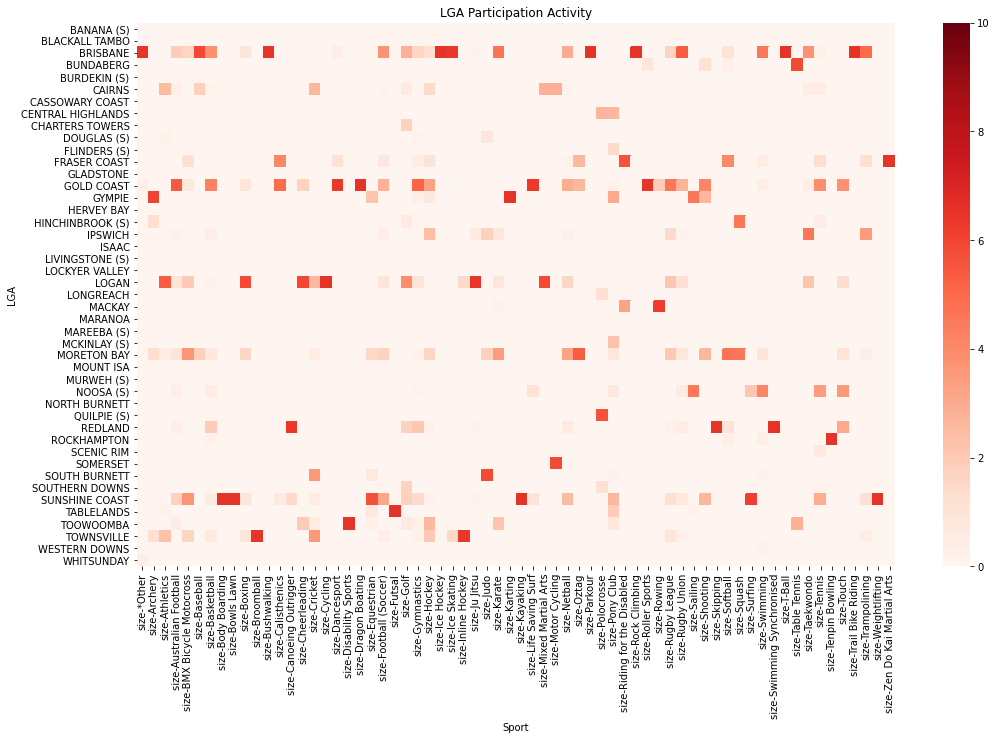

In [41]:
#calculating the data further for easier viewing on heatmap
qldCal = (qldPivot - qldPivot.mean())/qldPivot.std()
plt.figure(figsize=(17,10))
sns.heatmap(qldCal, vmin = 0, vmax = 10, center = 5, cmap = 'Reds')
plt.title('LGA Participation Activity')
plt.xlabel('Sport')
plt.ylabel('LGA')

After joining both datasets together and visualising it through a heatmap, the chosen sport distribution across LGA's is very diverse. There is no patterns or popular sports that can be chosen. We can see certain LGA's which have chosen more sports, these include Brisbane, Gold Coast, Logan, and Sunshine Coast. This is expected however because these are the more popular LGA's of Queensland. Same thing can be said if it were NSW, Sydney would overcrowd the rest of the data. 